# Barplots - correlations on test

In [1]:
import os
import anndata
import crested
import keras
import numpy as np
import warnings
from contextlib import redirect_stderr, redirect_stdout
from io import StringIO

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

# Comprehensive TensorFlow/XLA warning suppression
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['XLA_FLAGS'] = '--xla_hlo_profile=false --xla_dump_to=/tmp/xla_dumps'
os.environ['CUDA_VISIBLE_DEVICES'] = os.environ.get('CUDA_VISIBLE_DEVICES', '0')

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

# Suppress all warnings
warnings.filterwarnings('ignore')

# Additional TensorFlow configuration
tf.config.experimental.enable_op_determinism()
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

2025-07-28 17:29:48.848004: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-28 17:29:48.873366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753716588.890994 2073398 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753716588.896438 2073398 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753716588.911758 2073398 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
data_files_root = "../../../../../../../data/hydrop_v2_paper/mcortex/paper_zips/10x_hydropv2_comparisons_data/anndatas"
checkpoint_root = "../../../../../../../data/hydrop_v2_paper/mcortex/paper_zips/10x_hydropv2_comparisons_models/finetuned"
experiment = "allcells_36kreads"
k_folds = 10
genome_path = "../../../../../../../data/genomes/refdata-cellranger-arc-mm10-2020-A-2.0.0/fasta/genome.fa"
consensus_regions_file = "../../../../../../../data/hydrop_v2_paper/mcortex/paper_zips/10x_hydropv2_comparisons_data/consensus_regions_mouse_cleanup_annot_all_data_fulldepth.bed"

In [3]:
genome = crested.Genome(genome_path, name="mm10")
crested.register_genome(genome)

2025-07-28T17:30:13.873109+0200 INFO Genome mm10 registered.


In [8]:
experiments = ["allcells_allreads", "limitedcells_allreads", "plus25cells_allreads", "plus50cells_allreads", "plus75cells_allreads"]
technologies = ["10x", "hydrop"]

# Model paths organized by technology, experiment
# note, we're storing all anndata paths, but in reality we're only testing on the "all cells, all reads" scenarios
model_paths = {}
anndata_paths = {}
for tech in technologies:
    anndata_paths[tech] = {}
    model_paths[tech] = {}
    for exp in experiments:
        folder_name = f"{tech}_{exp}"
        if not (os.path.exists(f"{checkpoint_root}/{folder_name}") and os.path.exists(f"{data_files_root}/{folder_name}/normalized_specific.h5ad")):
            continue
        model_paths[tech][exp] = f"{checkpoint_root}/{folder_name}/"
        anndata_paths[tech][exp] = f"{data_files_root}/{folder_name}/normalized_specific.h5ad"

# remove 10x all cells reads (same nr of cells as limited cells for 10x)
if "allcells_allreads" in model_paths["10x"]:
    del model_paths["10x"]["allcells_allreads"]
    del anndata_paths["10x"]["allcells_allreads"]

In [14]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr  # Changed from spearmanr to pearsonr
from sklearn.metrics import mean_squared_error
import numpy as np

def compute_validation_metrics(tech, exp, n_folds=10):
    """
    Compute validation metrics (correlations, MSE, loss) between predictions and ground truth 
    for validation set across all folds for a given technology and experiment.
    
    Parameters:
    - tech: Technology ("10x" or "hydrop")
    - exp: Experiment name
    - model_type: "baseline" or "finetune"
    - n_folds: Number of folds (default 10)
    
    Returns:
    - Dictionary with correlations, mse_values, and loss_values for each fold
    """
    # Load anndata
    # adata_path = anndata_paths[tech][exp][model_type]
    if tech == "10x":
        adata_path = anndata_paths[tech][exp]
    elif tech == "hydrop":
        # test all on the allcells_allreads test data
        adata_path = anndata_paths[tech]["allcells_allreads"]
    adata = anndata.read_h5ad(adata_path)
    
    # Load models (suppress loading output)
    model_dir = model_paths[tech][exp]
    models = []
    for fold in range(n_folds):
        model_path = os.path.join(model_dir, f"fold_{fold}.keras")
        # Redirect stderr/stdout during model loading
        with redirect_stderr(StringIO()), redirect_stdout(StringIO()):
            model = keras.models.load_model(model_path, compile=False)
        models.append(model)
    
    # assert all models same n params
    n_params = [model.count_params() for model in models]
    if len(set(n_params)) != 1:
        raise ValueError("Not all models have the same number of parameters.")

    # Initialize the loss function used during training
    loss_fn = crested.tl.losses.CosineMSELogLoss(max_weight=1.0)

    correlations = []
    mse_values = []
    loss_values = []
    
    for fold in range(n_folds):
        # Get validation regions for this fold
        val_mask = adata.var[f"fold_{fold}"] == "val"
        val_regions = adata.var[val_mask].index.tolist()
        
        # Get ground truth for validation regions
        ground_truth = adata.X[:, val_mask].T  # Shape: (n_regions, n_celltypes)
        
        # Get predictions (completely suppress all output)
        with redirect_stderr(StringIO()), redirect_stdout(StringIO()):
            predictions = crested.tl.predict(
                input=val_regions,
                model=models[fold],
                verbose=0
            )
        
        # Compute correlation for each cell type and average
        fold_correlations = []
        for celltype_idx in range(ground_truth.shape[1]):
            corr, _ = pearsonr(ground_truth[:, celltype_idx], predictions[:, celltype_idx])
            if not np.isnan(corr):
                fold_correlations.append(corr)
        
        # Average correlation across cell types for this fold
        avg_correlation = np.mean(fold_correlations) if fold_correlations else 0
        correlations.append(avg_correlation)
        
        # Compute MSE (mean across all cell types and regions)
        mse = mean_squared_error(ground_truth.flatten(), predictions.flatten())
        mse_values.append(mse)
        
        # Compute validation loss using CosineMSELogLoss
        val_loss = loss_fn(ground_truth.astype(np.float32), predictions.astype(np.float32))
        if hasattr(val_loss, 'numpy'):
            val_loss = val_loss.numpy()
        if isinstance(val_loss, np.ndarray):
            val_loss = np.mean(val_loss)
        loss_values.append(float(val_loss))
        print(f"Fold {fold}: Corr={avg_correlation:.4f}, MSE={mse:.6f}, Loss={val_loss:.6f}")
    
    return {
        'correlations': correlations,
        'mse_values': mse_values,
        'loss_values': loss_values
    }

In [18]:
def plot_correlation_comparison(validation_results, figsize=(10, 6)):
    """
    Create a single bar plot with 10x on the left and Hydrop experiments in descending order on the right.
    
    Parameters:
    - validation_results: Dictionary with structure {tech: {exp: {'correlations': [values]}}}
    - figsize: Figure size tuple
    """
    # Extract 10x data (only allcells_allreads)
    tenx_corrs = validation_results['10x']['limitedcells_allreads']['correlations']
    tenx_mean = np.mean(tenx_corrs)
    tenx_std = np.std(tenx_corrs)
    
    # Extract Hydrop data and sort by mean correlation (descending)
    hydrop_data = []
    for exp in experiments:
        if exp in validation_results['hydrop']:
            corrs = validation_results['hydrop'][exp]['correlations']
            mean_corr = np.mean(corrs)
            std_corr = np.std(corrs)
            hydrop_data.append((exp, mean_corr, std_corr, corrs))
    
    # Sort by mean correlation (descending)
    hydrop_data.sort(key=lambda x: x[1], reverse=True)
    
    # Prepare data for plotting
    all_means = [tenx_mean]
    all_stds = [tenx_std]
    all_labels = ['10x']
    all_colors = ['#0072B2']
    
    # Add Hydrop data
    for exp, mean_corr, std_corr, _ in hydrop_data:
        all_means.append(mean_corr)
        all_stds.append(std_corr)
        # Create cleaner labels for Hydrop experiments
        if exp == 'limitedcells_allreads':
            label = 'Hydrop downsampled'
        elif exp == "allcells_allreads":
            label = "Hydrop all cells"
        else:
            # Extract number from experiment name
            num = exp.split('plus')[1].split('cells')[0]
            label = f'Hydrop+{num}'
        all_labels.append(label)
        all_colors.append('#E69F00')
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    x = np.arange(len(all_labels))
    
    # Create bars
    bars = ax.bar(x, all_means, yerr=all_stds, capsize=5, alpha=0.8, color=all_colors)
    
    # Customize the plot
    ax.set_ylabel('Test Pearson Correlation', fontsize=12)
    ax.set_title('Model Performance: 10x vs Hydropv2 Cell Scaling\n(Finetuned Models)', fontsize=14, pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(all_labels, rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, mean, std in zip(bars, all_means, all_stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
               f'{mean:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    return fig, ax

In [16]:
# Compute validation metrics for all experiments (finetune models only)
validation_results = {}

for tech in technologies:
    validation_results[tech] = {}
    
    for exp in experiments:
        if tech not in model_paths or exp not in model_paths[tech]:
            continue
        print(f"Processing {tech} {exp}...")
        metrics = compute_validation_metrics(tech, exp)
        validation_results[tech][exp] = metrics

Processing 10x limitedcells_allreads...
Fold 0: Corr=0.5272, MSE=0.051537, Loss=1.504251
Fold 1: Corr=0.4947, MSE=0.037424, Loss=1.512402
Fold 2: Corr=0.5263, MSE=0.062033, Loss=1.492637
Fold 3: Corr=0.6132, MSE=0.085118, Loss=1.243545
Fold 4: Corr=0.7220, MSE=0.283302, Loss=1.084559
Fold 5: Corr=0.7025, MSE=0.233785, Loss=0.961907
Fold 6: Corr=0.6713, MSE=0.180654, Loss=0.926726
Fold 7: Corr=0.6243, MSE=0.121941, Loss=1.024091
Fold 8: Corr=0.6482, MSE=0.127572, Loss=0.985504
Fold 9: Corr=0.6103, MSE=0.146973, Loss=1.134126
Processing hydrop allcells_allreads...
Fold 0: Corr=0.4921, MSE=0.033552, Loss=1.011353
Fold 1: Corr=0.4833, MSE=0.038441, Loss=1.017197
Fold 2: Corr=0.5116, MSE=0.049058, Loss=0.915013
Fold 3: Corr=0.5885, MSE=0.052573, Loss=0.717758
Fold 4: Corr=0.7002, MSE=0.187617, Loss=0.718388
Fold 5: Corr=0.6947, MSE=0.160110, Loss=0.419825
Fold 6: Corr=0.6403, MSE=0.133909, Loss=0.406159
Fold 7: Corr=0.6124, MSE=0.079014, Loss=0.464321
Fold 8: Corr=0.6607, MSE=0.073176, Loss

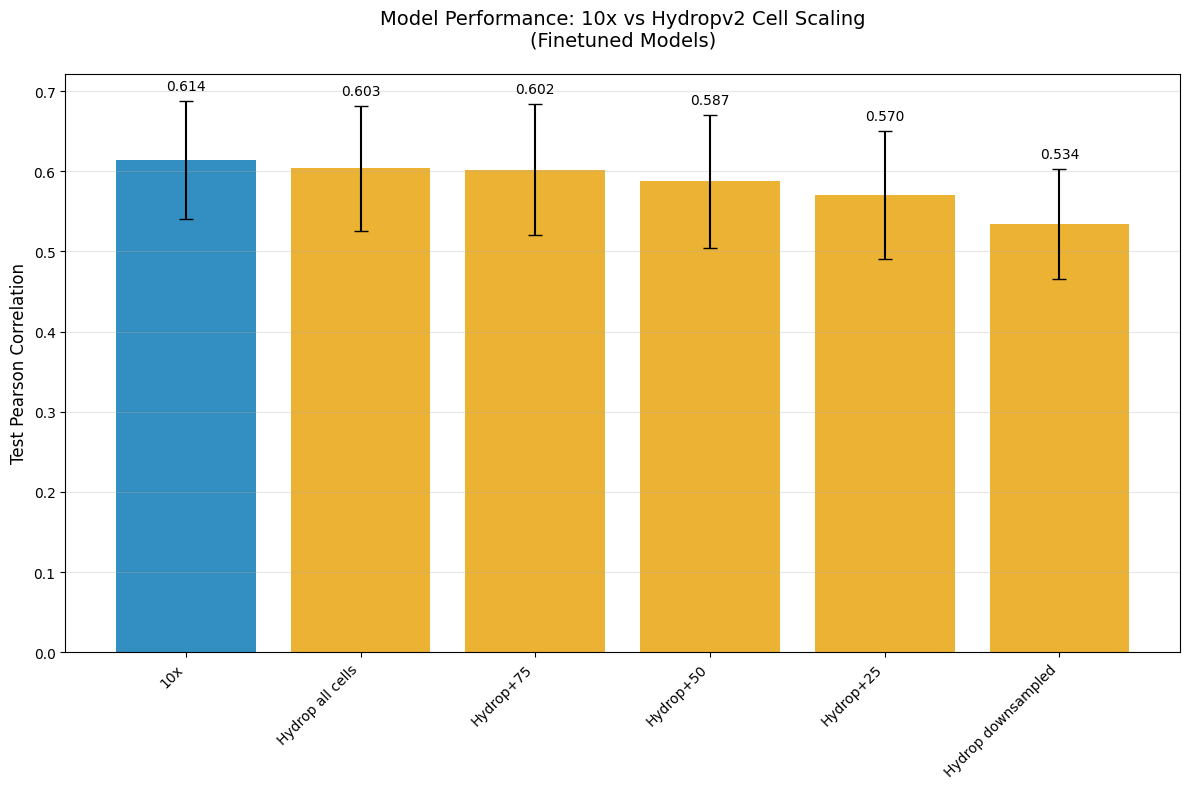

In [19]:
%matplotlib inline
# Create the grouped bar chart
fig, ax = plot_correlation_comparison(validation_results, figsize=(12, 8))
plt.show()

In [20]:
# save as editable pdf
fig.savefig("../../../plots/correlation_barplots_downsampled_comparisons.pdf", bbox_inches='tight', format='pdf', dpi=400)